    Gifford AT, Lahner B, Saba-Sadiya S, Vilas MG, Lascelles A, Oliva A, Kay K, Roig G, Cichy RM. 2023. The Algonauts Project 2023 Challenge: How the Human Brain Makes Sense of Natural Scenes. arXiv preprint, arXiv:2301.03198. DOI: https://doi.org/10.48550/arXiv.2301.03198 

    Allen EJ, St-Yves G, Wu Y, Breedlove JL, Prince JS, Dowdle LT, Nau M, Caron B, Pestilli F, Charest I, Hutchinson JB, Naselaris T, Kay K. 2022. A massive 7T fMRI dataset to bridge cognitive neuroscience and computational intelligence. Nature Neuroscience, 25(1):116–126. DOI: https://doi.org/10.1038/s41593-021-00962-x 

In [1]:
import sys
import os
from os.path import exists
import glob
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import xarray as xr

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models


from scipy.spatial.distance import squareform, pdist
from scipy.cluster.hierarchy import fcluster

import gdown

from sklearn.manifold import MDS
from sklearn.decomposition import PCA

import pickle

#### Extract the shared images

In [ ]:
fnames01 = [f for f in os.listdir('data/algonauts_data/subj01/training_split/training_images') if not f.startswith("._")]
fnames02 = [f for f in os.listdir('algonauts_data/subj02/training_split/training_images') if not f.startswith("._")]
fnames03 = [f for f in os.listdir('algonauts_data/subj03/training_split/training_images') if not f.startswith("._")]
fnames04 = [f for f in os.listdir('algonauts_data/subj04/training_split/training_images') if not f.startswith("._")]
fnames05 = [f for f in os.listdir('algonauts_data/subj05/training_split/training_images') if not f.startswith("._")]
fnames06 = [f for f in os.listdir('algonauts_data/subj06/training_split/training_images') if not f.startswith("._")]
fnames07 = [f for f in os.listdir('algonauts_data/subj07/training_split/training_images') if not f.startswith("._")]
fnames08 = [f for f in os.listdir('algonauts_data/subj08/training_split/training_images') if not f.startswith("._")]

fnames01.sort()
fnames02.sort()
fnames03.sort()
fnames04.sort()
fnames05.sort()
fnames06.sort()
fnames07.sort()
fnames08.sort()

fnames = []
fnames.append(fnames01)
fnames.append(fnames02)
fnames.append(fnames03)
fnames.append(fnames04)
fnames.append(fnames05)
fnames.append(fnames06)
fnames.append(fnames07)
fnames.append(fnames08)

nsdtags = []
nsdtags.append( [fnames01[i][11:] for i in range(len(fnames01))])
nsdtags.append([fnames02[i][11:] for i in range(len(fnames02))])
nsdtags.append([fnames03[i][11:] for i in range(len(fnames03))])
nsdtags.append([fnames04[i][11:] for i in range(len(fnames04))])
nsdtags.append( [fnames05[i][11:] for i in range(len(fnames05))])
nsdtags.append([fnames06[i][11:] for i in range(len(fnames06))])
nsdtags.append( [fnames07[i][11:] for i in range(len(fnames07))])
nsdtags.append( [fnames08[i][11:] for i in range(len(fnames08))])


FileNotFoundError: [Errno 2] No such file or directory: 'data/algonauts_data/subj02/training_split/training_images'

In [6]:
len(fnames01)

8841

In [3]:
shared = []

for j, nsdtag in enumerate(nsdtags):
    shared.append({})
    for i, item in enumerate(nsdtag):
        if (item in nsdtags[0] and item in nsdtags[1] and item in nsdtags[2] and item in nsdtags[3] and item in nsdtags[4] and item in nsdtags[5] and item in nsdtags[6] and item in nsdtags[7]):
            shared[j].update({i: fnames[j][i]})

In [ ]:
images = []
for ind in range(len(shared[0])):
    image_path = 'algonauts_data/subj0' + str(i+1) +  '/training_split/training_images/' + shared[i][list(shared[i].keys())[ind]]
    try:
        img = Image.open(image_path)
        img_array = np.array(img)
        images.append(img_array)
    except Exception as e:
        print(f"Error loading image {image_file}: {e}")

shared_images = np.stack(images)

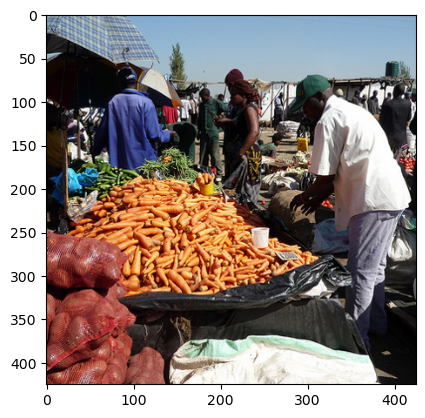

In [6]:
ind = 0
subjind = 1
sample_image = plt.imread('algonauts_data/subj0' + str(subjind+1) +  '/training_split/training_images/' + shared[subjind][list(shared[subjind].keys())[ind]] )
plt.imshow(sample_image)

In [280]:
brainData = []
for i in range(len(shared)):
    brainData.append({})
    shared_inds = list(shared[i].keys())

    fmri_dir = os.path.join('/Users/sharvey/Documents/decoding-similarity/algonauts_data/subj0' + str(i+1) + '/', 'training_split', 'training_fmri')
    lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
    rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

    brainData[i].update({"lh_all": lh_fmri[shared_inds]})
    brainData[i].update({"rh_all": rh_fmri[shared_inds]})


    data_dir = os.path.join(os.getcwd(), 'algonauts_data/subj0' + str(i+1))

    # hemisphere =  ['lh', 'rh'] #{allow-input: true}
    # hemi = "lh"
    for hemi in ['lh', 'rh']: 
        for roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal", "all-prf-visual", "all-bodies", "all-faces", "all-places", "all-words", "all-streams"]:

            # Define the ROI class based on the selected ROI
            if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "all-prf-visual"]:
                roi_class = 'prf-visualrois'
            elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies", "all-bodies"]:
                roi_class = 'floc-bodies'
            elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "all-faces"]:
                roi_class = 'floc-faces'
            elif roi in ["OPA", "PPA", "RSC", "all-places"]:
                roi_class = 'floc-places'
            elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "all-words"]:
                roi_class = 'floc-words'
            elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal", "all-streams"]:
                roi_class = 'streams'


            # Load the ROI brain surface maps
            roi_class_dir = os.path.join(data_dir, 'roi_masks',
                hemi[0]+'h.'+roi_class+'_challenge_space.npy')
            roi_map_dir = os.path.join(data_dir, 'roi_masks',
                'mapping_'+roi_class+'.npy')
            challenge_roi_class = np.load(roi_class_dir)
            roi_map = np.load(roi_map_dir, allow_pickle=True).item()

            # Select the vertices corresponding to the ROI of interest
            if roi[0:3] == 'all':  
                roi_mapping = list(roi_map.keys())
                bool_roi = np.asarray(np.isin(challenge_roi_class, roi_mapping))
            else:
                roi_mapping = list(roi_map.keys())[list(roi_map.values()).index(roi)]
                challenge_roi = np.asarray(challenge_roi_class == roi_mapping, dtype=int)
                bool_roi = challenge_roi == 1

            filtered_data = []

            for j in range(len(brainData[i][hemi + "_all"])):
                filtered_data.append(brainData[i][hemi + "_all"][j][bool_roi])

            brainData[i].update({hemi + '_' + roi: np.array(filtered_data)})


In [282]:
with open('algonauts_brain_data_joint_images_8subjects.pkl', 'wb') as f:
    pickle.dump(brainData, f)

In [253]:
np.save('algonauts_joint_images_8subjects.npy', shared_images)

## Save all images and brain responses for one subject

In [2]:
# fnames01 = [f for f in os.listdir('data/algonauts_data/subj01/training_split/training_images') if not f.startswith("._")]
fnames02 = [f for f in os.listdir('data/algonauts_data/subj02/training_split/training_images') if not f.startswith("._")]
# fnames03 = [f for f in os.listdir('algonauts_data/subj03/training_split/training_images') if not f.startswith("._")]
# fnames04 = [f for f in os.listdir('algonauts_data/subj04/training_split/training_images') if not f.startswith("._")]
# fnames05 = [f for f in os.listdir('algonauts_data/subj05/training_split/training_images') if not f.startswith("._")]
# fnames06 = [f for f in os.listdir('algonauts_data/subj06/training_split/training_images') if not f.startswith("._")]
# fnames07 = [f for f in os.listdir('algonauts_data/subj07/training_split/training_images') if not f.startswith("._")]
# fnames08 = [f for f in os.listdir('algonauts_data/subj08/training_split/training_images') if not f.startswith("._")]

# fnames01.sort()
fnames02.sort()
# fnames03.sort()
# fnames04.sort()
# fnames05.sort()
# fnames06.sort()
# fnames07.sort()
# fnames08.sort()

fnames = []
# fnames.append(fnames01)
fnames.append(fnames02)
# fnames.append(fnames03)
# fnames.append(fnames04)
# fnames.append(fnames05)
# fnames.append(fnames06)
# fnames.append(fnames07)
# fnames.append(fnames08)

# nsdtags = []
# nsdtags.append( [fnames01[i][11:] for i in range(len(fnames01))])

nsdtags = []
nsdtags.append( [fnames02[i][11:] for i in range(len(fnames02))])

imginds = []
# imginds.append( [int(fnames01[i][6:10]) for i in range(len(fnames01))])
imginds.append( [int(fnames02[i][6:10]) for i in range(len(fnames02))])

# nsdtags.append([fnames02[i][11:] for i in range(len(fnames02))])
# nsdtags.append([fnames03[i][11:] for i in range(len(fnames03))])
# nsdtags.append([fnames04[i][11:] for i in range(len(fnames04))])
# nsdtags.append( [fnames05[i][11:] for i in range(len(fnames05))])
# nsdtags.append([fnames06[i][11:] for i in range(len(fnames06))])
# nsdtags.append( [fnames07[i][11:] for i in range(len(fnames07))])
# nsdtags.append( [fnames08[i][11:] for i in range(len(fnames08))])


FileNotFoundError: [Errno 2] No such file or directory: 'data/algonauts_data/subj02/training_split/training_images'

In [11]:
for j, nsdtag in enumerate(nsdtags):
    print(nsdtag)

['nsd-00013.png', 'nsd-00027.png', 'nsd-00071.png', 'nsd-00085.png', 'nsd-00088.png', 'nsd-00093.png', 'nsd-00095.png', 'nsd-00099.png', 'nsd-00103.png', 'nsd-00110.png', 'nsd-00113.png', 'nsd-00119.png', 'nsd-00140.png', 'nsd-00144.png', 'nsd-00154.png', 'nsd-00155.png', 'nsd-00156.png', 'nsd-00169.png', 'nsd-00176.png', 'nsd-00179.png', 'nsd-00189.png', 'nsd-00192.png', 'nsd-00194.png', 'nsd-00198.png', 'nsd-00200.png', 'nsd-00204.png', 'nsd-00206.png', 'nsd-00214.png', 'nsd-00221.png', 'nsd-00222.png', 'nsd-00224.png', 'nsd-00228.png', 'nsd-00236.png', 'nsd-00239.png', 'nsd-00242.png', 'nsd-00246.png', 'nsd-00251.png', 'nsd-00266.png', 'nsd-00269.png', 'nsd-00270.png', 'nsd-00295.png', 'nsd-00304.png', 'nsd-00317.png', 'nsd-00318.png', 'nsd-00322.png', 'nsd-00327.png', 'nsd-00351.png', 'nsd-00356.png', 'nsd-00384.png', 'nsd-00392.png', 'nsd-00398.png', 'nsd-00402.png', 'nsd-00409.png', 'nsd-00418.png', 'nsd-00425.png', 'nsd-00429.png', 'nsd-00444.png', 'nsd-00452.png', 'nsd-00459.pn

In [62]:
all

[{0: 'train-0001_nsd-00013.png',
  1: 'train-0002_nsd-00027.png',
  2: 'train-0003_nsd-00071.png',
  3: 'train-0004_nsd-00085.png',
  4: 'train-0005_nsd-00088.png',
  5: 'train-0006_nsd-00093.png',
  6: 'train-0007_nsd-00095.png',
  7: 'train-0008_nsd-00099.png',
  8: 'train-0009_nsd-00103.png',
  9: 'train-0010_nsd-00110.png',
  10: 'train-0011_nsd-00113.png',
  11: 'train-0012_nsd-00119.png',
  12: 'train-0013_nsd-00140.png',
  13: 'train-0014_nsd-00144.png',
  14: 'train-0016_nsd-00154.png',
  15: 'train-0017_nsd-00155.png',
  16: 'train-0018_nsd-00156.png',
  17: 'train-0019_nsd-00169.png',
  18: 'train-0020_nsd-00176.png',
  19: 'train-0021_nsd-00179.png',
  20: 'train-0022_nsd-00189.png',
  21: 'train-0023_nsd-00192.png',
  22: 'train-0024_nsd-00194.png',
  23: 'train-0025_nsd-00198.png',
  24: 'train-0026_nsd-00200.png',
  25: 'train-0027_nsd-00204.png',
  26: 'train-0028_nsd-00206.png',
  27: 'train-0029_nsd-00214.png',
  28: 'train-0030_nsd-00221.png',
  29: 'train-0031_nsd-00

In [19]:
all = []

for j, nsdtag in enumerate(nsdtags):
    all.append({})
    for i, item in enumerate(nsdtag):
        # if i >= 5000:
        #     break
        all[j].update({i: fnames[j][i]})

In [85]:
all = []

for j, imgind in enumerate(imginds):
    all.append({})
    for i, item in enumerate(imgind):
        # if i >= 5000:
        #     break
        all[j].update({item: fnames[j][i]})

In [87]:
list(all[0].keys())[-1]

9841

In [88]:
len(all[0])

8841

In [90]:
i = 0
images = []
for ind in range(len(all[0])):
    image_path = 'data/algonauts_data/subj0' + str(i+1) +  '/training_split/training_images/' + all[i][list(all[i].keys())[ind]]
    try:
        img = Image.open(image_path)
        img_array = np.array(img)
        images.append(img_array)
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")

all_images = np.stack(images)

In [100]:
list(all[subjind].keys())[-1]

9841

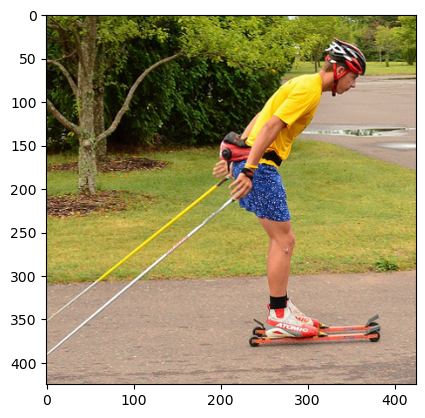

In [96]:
ind = 6000
subjind = 0
sample_image = plt.imread('data/algonauts_data/subj0' + str(subjind+1) +  '/training_split/training_images/' + all[subjind][list(all[subjind].keys())[ind]] )
plt.imshow(sample_image)

In [114]:
[all_ind-1 for all_ind in list(all[i].keys())]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 59,
 60,
 62,
 63,
 64,
 65,
 67,
 68,
 69,
 72,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 100,
 101,
 102,
 103,
 104,
 105,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 181,
 182,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 

In [115]:
brainData = []
for i in range(len(all)):
    brainData.append({})
    all_inds = [all_ind-1 for all_ind in list(all[i].keys())] #list(all[i].keys())

    fmri_dir = os.path.join('data/algonauts_data/subj0' + str(i+1) + '/', 'training_split', 'training_fmri')
    lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
    rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

    brainData[i].update({"lh_all": lh_fmri[all_inds]})
    brainData[i].update({"rh_all": rh_fmri[all_inds]})


    data_dir = os.path.join(os.getcwd(), 'data/algonauts_data/subj0' + str(i+1))

    # hemisphere =  ['lh', 'rh'] #{allow-input: true}
    # hemi = "lh"
    for hemi in ['lh', 'rh']: 
        for roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal", "all-prf-visual", "all-bodies", "all-faces", "all-places", "all-words", "all-streams"]:

            # Define the ROI class based on the selected ROI
            if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "all-prf-visual"]:
                roi_class = 'prf-visualrois'
            elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies", "all-bodies"]:
                roi_class = 'floc-bodies'
            elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "all-faces"]:
                roi_class = 'floc-faces'
            elif roi in ["OPA", "PPA", "RSC", "all-places"]:
                roi_class = 'floc-places'
            elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "all-words"]:
                roi_class = 'floc-words'
            elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal", "all-streams"]:
                roi_class = 'streams'


            # Load the ROI brain surface maps
            roi_class_dir = os.path.join(data_dir, 'roi_masks',
                hemi[0]+'h.'+roi_class+'_challenge_space.npy')
            roi_map_dir = os.path.join(data_dir, 'roi_masks',
                'mapping_'+roi_class+'.npy')
            challenge_roi_class = np.load(roi_class_dir)
            roi_map = np.load(roi_map_dir, allow_pickle=True).item()

            # Select the vertices corresponding to the ROI of interest
            if roi[0:3] == 'all':  
                roi_mapping = list(roi_map.keys())
                bool_roi = np.asarray(np.isin(challenge_roi_class, roi_mapping))
            else:
                roi_mapping = list(roi_map.keys())[list(roi_map.values()).index(roi)]
                challenge_roi = np.asarray(challenge_roi_class == roi_mapping, dtype=int)
                bool_roi = challenge_roi == 1

            filtered_data = []

            for j in range(len(brainData[i][hemi + "_all"])):
                filtered_data.append(brainData[i][hemi + "_all"][j][bool_roi])

            brainData[i].update({hemi + '_' + roi: np.array(filtered_data)})


In [118]:
brainData[0]["lh_all"].shape

(8841, 19004)

In [119]:
with open('algonauts_brain_data_all_training_images_subj01.pkl', 'wb') as f:
    pickle.dump(brainData, f)

In [120]:
np.save('algonauts_all_training_images_subj01.npy', all_images)